# Tradesy Lists Dataset Project
## Predicting Whether a User Will *Want* an Item

**Dataset:** Tradesy user–item lists (UCSD / McAuley Lab)  
**Course:** CSE 158 / 258 – Recommender Systems and Web Mining  

Each record in the dataset looks like:

```json
{
  "uid": "1",
  "lists": {
    "bought": [...],
    "selling": [...],
    "want": [...],
    "sold": [...]
  }
}
```

# Section 1: Identify the Predictive Task

We as a group are trying to:

> **Predict whether a user will *want* a given item.**

Concretely:
- **Positive examples**: items that appear in a user's `want` list.
- **Negative examples**: items that the user has *never* marked as `want` (sampled from the global item set).


## 1.1 Predictive Task Definition

**Task:** Given a user \(u\) and item \(i\), predict whether \(i\) is in the user's `want` list.

- **Positive instances:** all \((u, i)\) pairs with \(i\) in `want`
- **Negative instances:** sampled \((u, j)\) pairs such that \(j\) is not in the user's `want` list

To keep the dataset manageable and balanced, we will sample a fixed number of negatives per positive:
- `NEG_PER_POS = 4` (i.e., 4 negatives for each positive example)


## 1.2 Evaluation Strategy and Baselines

### How We Will Evaluate the Model

We will evaluate our model using multiple metrics to capture different aspects of performance:

- **Accuracy**: Overall correctness of predictions
- **Precision**: Of items predicted as "want", how many are actually wanted
- **Recall**: Of items actually wanted, how many did we correctly identify
- **F1-score**: Harmonic mean of precision and recall, balancing both concerns
- **ROC-AUC**: Area under the ROC curve, measuring the model's ability to distinguish between positive and negative examples across all thresholds
- **Precision@k**: For ranking evaluation, the fraction of positive items in the top-k recommendations per user

These metrics are appropriate because:
- **ROC-AUC** is robust to class imbalance and provides a threshold-independent measure of discrimination ability
- **Precision and Recall** are interpretable for the business context (avoiding false positives vs. capturing all wants)
- **Precision@k** aligns with the recommender system use case where we care about top recommendations

### Relevant Baselines for Comparison

1. **Random Baseline**: Random predictions serve as a trivial lower bound, demonstrating that any signal is better than chance
2. **Item Popularity Baseline**: Uses only item popularity (how many users want each item) as a predictor. This captures the "wisdom of the crowd" effect and serves as a simple but non-trivial baseline
3. **Logistic Regression**: Our main model that combines multiple features (user activity, item popularity, user-item interactions)

### How We Will Assess Validity of Model Predictions

We use a **stratified train/validation split** (80/20) to assess validity:

- **Data independence**: Validation examples are unseen during training, providing unbiased generalization estimates
- **Class balance**: Stratification preserves the positive/negative ratio in both sets
- **Sample size**: With ~460K validation pairs, we have statistically stable metric estimates
- **Cold-start simulation**: Validation pairs simulate prediction for new user–item combinations

See Section 1.3 below for detailed validity assessment discussion.


## 1.3 Dataset Construction and Negative Sampling

### Data Processing Rationale

**Negative Sampling Strategy**: We use **uniform random sampling** of negatives from the global item set. This approach:

- **Balances the dataset**: With `NEG_PER_POS = 4`, we create a 20% positive rate (1 positive : 4 negatives), which is more balanced than the true distribution (where most user–item pairs are negative). This helps with:
  - Training stability: prevents the model from trivially predicting "negative" for everything
  - Metric interpretation: allows meaningful computation of precision, recall, and F1-score
  - Computational efficiency: limits dataset size while maintaining signal

- **Uniform sampling rationale**: We sample uniformly from all items (not popularity-weighted) because:
  - It's simple and computationally efficient
  - It provides a diverse set of negative examples
  - In reality, users encounter both popular and niche items, so uniform sampling is a reasonable approximation

- **Alternative approaches considered but not used**:
  - **Popularity-weighted sampling**: Would better reflect real-world item exposure but requires more complex implementation
  - **Hard negative mining**: Sampling items that are popular but not wanted by the user could improve learning, but adds complexity
  - **Temporal negatives**: Using items the user interacted with (bought/sold) but didn't want could be informative, but we preserve these as features instead

**Dataset Size**: With ~457K positive examples (want pairs) and 4 negatives per positive, we create ~2.3M training pairs. This provides:
- Sufficient data for learning meaningful patterns
- Manageable computational requirements
- Representative coverage of the user–item space


## 1.4 Validity Assessment and Evaluation Strategy

#### Why Train/Validation Split is Appropriate

We use a **stratified train/validation split** (80/20) because:
- **Data independence**: Validation examples are unseen during training, providing unbiased generalization estimates
- **Class balance**: Stratification preserves the 20% positive rate in both sets, ensuring representative evaluation
- **Sample size**: With ~460K validation pairs (~92K positives), we have statistically stable metric estimates
- **Standard practice**: Random splitting of user–item pairs is appropriate for implicit feedback tasks

#### How the Validation Set Reflects Real-World Performance

- **Cold-start simulation**: Validation pairs are unseen during training, simulating prediction for new user–item combinations
- **Representative distribution**: Negative sampling matches training strategy, reflecting realistic scenarios
- **Temporal assumption**: Random split assumes stable preferences; temporal splits would be ideal but require timestamps

#### Potential Limitations

1. **Temporal effects**: Random split doesn't account for preference drift over time; time-based splits would be more realistic
2. **Data leakage**: Item popularity (`item_want_pop`) is computed from full dataset; strict evaluation would use only training data
3. **Negative sampling bias**: Uniform sampling doesn't reflect that users encounter popular items more often
4. **User–item dependencies**: Validation users/items may appear in training, overestimating cold-start performance
5. **Class imbalance**: 20% positive rate is higher than reality; we report multiple metrics (ROC-AUC, Precision@k) to account for this

#### Generalization Considerations

- **Train–validation gap**: We monitor performance differences to detect overfitting
- **Feature stability**: We assume feature distributions remain stable; distribution shifts could degrade performance
- **Model complexity**: Simple models (logistic regression) reduce overfitting risk compared to more complex alternatives


# Section 2: Exploratory Analysis, Data Collection, Pre-processing, and Discussion

## 2.1 Dataset Context and Background

**Tradesy** is an online marketplace for buying and selling pre-owned fashion items, particularly luxury and designer clothing, shoes, and accessories. The platform allows users to create various lists to organize their interactions with items:

- **`bought`**: Items the user has purchased
- **`selling`**: Items the user is currently listing for sale
- **`want`**: Items the user wants to purchase (a wishlist)
- **`sold`**: Items the user has successfully sold

**Data Collection**: This dataset was collected and made available by the UCSD / McAuley Lab, which specializes in recommendation systems and e-commerce research. The data represents user–item interactions from the Tradesy platform, capturing implicit feedback through user-curated lists rather than explicit ratings.

**Dataset Purpose**: This dataset is designed for studying **implicit feedback recommendation systems**, where user preferences are inferred from actions (creating lists, purchasing, selling) rather than explicit ratings. It's particularly useful for:
- Understanding user behavior in fashion marketplaces
- Building recommendation systems for e-commerce
- Studying implicit feedback patterns (what users want vs. what they buy)
- Analyzing the relationship between different types of user–item interactions

**Dataset Characteristics**:
- **Format**: JSON-lines (one user record per line)
- **Structure**: Each record contains a user ID and nested lists of item IDs
- **Implicit feedback**: No explicit ratings; preferences inferred from list membership
- **Sparsity**: Typical of recommendation datasets—most user–item pairs have no interaction

This dataset is commonly used in recommender systems research and is well-suited for studying collaborative filtering, matrix factorization, and other recommendation algorithms that work with implicit feedback.


In [ ]:
# === Setup & Imports ===

# Standard library imports for file I/O and data structures
import gzip
import json
import math
from collections import defaultdict, Counter

# Scientific computing and data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Set random seed for reproducibility across all random operations
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure pandas display options for better readability
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Libraries imported.")

Libraries imported.


## 2.2 Data Loading

The Tradesy lists dataset is distributed as a **JSON-lines** file: each line is one user record.

We define helpers to:

- Open the file (supports gzip or plain text)
- Stream the records one by one
- Optionally limit to a subset of users for faster experimentation


In [ ]:
# === File path (EDIT THIS to match your local filename) ===

# Path to the Tradesy dataset file (JSON-lines format)
TRADESY_LISTS_PATH = "tradesy.json"  # e.g., the file you showed with 'uid' and 'lists'

# For development: limit how many users to load (set to None to use all)
# This allows faster iteration during development by processing a subset
MAX_USERS = None  # e.g., 50_000 for faster runs during development


def open_maybe_gzip(path):
    """
    Open a file that may be gzip-compressed based on its magic bytes.
    
    This function automatically detects whether a file is gzip-compressed by
    reading the first two bytes (magic number). If it's gzip, opens with
    gzip.open(); otherwise opens as a regular text file.
    
    Args:
        path (str): Path to the file to open
        
    Returns:
        file object: Opened file handle (gzip or regular text)
    """
    # Read first 2 bytes to check for gzip magic number
    with open(path, "rb") as f:
        magic = f.read(2)
    # gzip magic header is 0x1f 0x8b
    if magic == b"\x1f\x8b":
        # File is gzip-compressed, open with gzip
        return gzip.open(path, "rt", encoding="utf-8")
    # Fallback: assume plain text JSON file
    return open(path, "r", encoding="utf-8")


def iter_users(path, max_users=None):
    """
    Yield parsed user records from the Tradesy lists file.
    
    This is a generator function that reads the JSON-lines file line by line,
    parses each line as a JSON object (or Python dict literal), and yields
    user records. This approach is memory-efficient for large files.
    
    Args:
        path (str): Path to the Tradesy dataset file
        max_users (int, optional): Maximum number of users to load.
                                   If None, loads all users. Defaults to None.
    
    Yields:
        dict: User record with 'uid' and 'lists' keys
    """
    users_read = 0
    # Open file (handles both gzip and plain text)
    with open_maybe_gzip(path) as f:
        for line in f:
            line = line.strip()
            # Skip empty lines
            if not line:
                continue
            try:
                # Try parsing as JSON first (standard format)
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    # Fallback: some files may use Python dict literal format
                    # Note: eval() is used here for course data only
                    obj = eval(line)  # noqa: S307 (trusted research data from course site)
            except Exception as e:
                # Skip malformed lines and continue processing
                print(f"Skipping malformed line: {e}")
                continue
            yield obj
            users_read += 1
            # Stop if we've reached the maximum number of users
            if max_users is not None and users_read >= max_users:
                break


# Quick smoke test: Load first 5 records to verify file format
example_records = []
for rec in iter_users(TRADESY_LISTS_PATH, max_users=5):
    example_records.append(rec)

print(f"Loaded {len(example_records)} example records.")
if example_records:
    print("Example record keys:", example_records[0].keys())
    print("Example lists keys:", example_records[0].get("lists", {}).keys())
    print("\nExample record:")
    print(example_records[0])

Loaded 5 example records.
Example record keys: dict_keys(['lists', 'uid'])
Example lists keys: dict_keys(['bought', 'selling', 'want', 'sold'])

Example record:
{'lists': {'bought': [], 'selling': [], 'want': [], 'sold': ['3', '2']}, 'uid': '1'}


## 2.3 Data Pre-processing: Flattening into a user–item interaction table

We will flatten the nested structure into a **long-form DataFrame** with columns:

- `user_id`
- `item_id`
- `list_type` ∈ {`bought`, `selling`, `want`, `sold`}

This will let us:

- Analyze list sizes and item popularity
- Construct positive/negative samples for the `want` prediction task


In [ ]:
# List types present in the dataset
# These represent the four types of user-item interactions in Tradesy
LIST_TYPES = ["bought", "selling", "want", "sold"]


def build_long_dataframe(path, max_users=None):
    """
    Convert nested user-item list structure into a long-form DataFrame.
    
    The input data has a nested structure where each user has multiple lists
    (bought, selling, want, sold), each containing item IDs. This function
    flattens this structure into a tabular format with one row per user-item-list
    combination.
    
    Args:
        path (str): Path to the Tradesy dataset file
        max_users (int, optional): Maximum number of users to process.
                                   If None, processes all users. Defaults to None.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['user_id', 'item_id', 'list_type']
                      Each row represents one user-item interaction in a specific list.
    """
    rows = []
    # Iterate through all user records
    for user_rec in iter_users(path, max_users=max_users):
        # Extract user ID and ensure it's a string
        uid = str(user_rec.get("uid"))
        # Get the lists dictionary (default to empty dict if missing)
        lists = user_rec.get("lists", {})
        
        # Process each list type (bought, selling, want, sold)
        for lt in LIST_TYPES:
            # Get items in this list type (default to empty list if missing)
            item_list = lists.get(lt, [])
            # Create a row for each item in this list
            for item_id in item_list:
                rows.append({
                    "user_id": uid,
                    "item_id": str(item_id),  # Ensure item_id is string
                    "list_type": lt,
                })
    
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(rows)
    print(f"Constructed long-form DataFrame with {len(df):,} rows.")
    return df


# Build the long-form interaction DataFrame
interactions_df = build_long_dataframe(TRADESY_LISTS_PATH, max_users=MAX_USERS)
interactions_df.head()

Constructed long-form DataFrame with 880,174 rows.


,user_id,item_id,list_type
0,1,3,sold
1,1,2,sold
2,2,466,bought
3,2,459,bought
4,2,457,bought


## 2.4 Exploratory Analysis

We begin by answering some basic questions:

- How many users and items are there?
- How many interactions per list type?
- How many *want* items per user?


#users: 128,152
#items: 352,865

Interactions per list_type:


list_type
want       457690
selling    286198
bought      68543
sold        67743
Name: count, dtype: int64


Summary of #want items per user:


count    78538.000000
mean         5.827625
std         25.553324
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       2396.000000
Name: item_id, dtype: float64

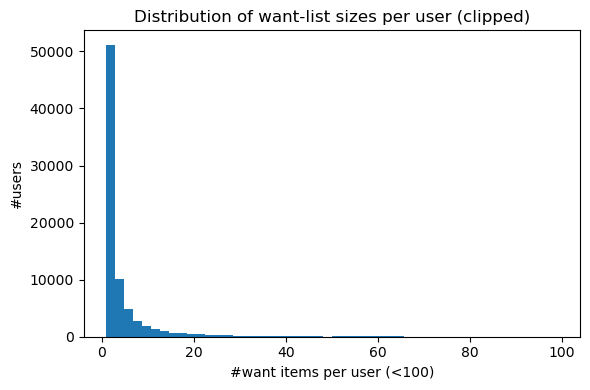

Users with 100+ wants: 474


In [ ]:
# Calculate basic dataset statistics
# Count unique users and items in the dataset
n_users = interactions_df["user_id"].nunique()
n_items = interactions_df["item_id"].nunique()
print(f"#users: {n_users:,}")
print(f"#items: {n_items:,}")

# Count interactions per list type to understand distribution
print("\nInteractions per list_type:")
display(interactions_df["list_type"].value_counts())

# Analyze 'want' list distribution per user
# Filter to only 'want' interactions
want_df = interactions_df[interactions_df["list_type"] == "want"].copy()
# Count unique items per user in their want list
want_per_user = want_df.groupby("user_id")["item_id"].nunique()

# Display summary statistics of want list sizes
print("\nSummary of #want items per user:")
display(want_per_user.describe())

# Create histogram for users with <100 want items (to visualize typical distribution)
subset = want_per_user[want_per_user < 100]

plt.figure(figsize=(6,4))
plt.hist(subset, bins=50)
plt.xlabel("#want items per user (<100)")
plt.ylabel("#users")
plt.title("Distribution of want-list sizes per user (clipped)")
plt.tight_layout()
plt.show()

# Count users with very large want lists (100+ items)
print("Users with 100+ wants:", (want_per_user >= 100).sum())


In [ ]:
# Count total interactions per user and per item (across all list types)
# This gives us user activity levels and item popularity
interactions_per_user = interactions_df.groupby("user_id")["item_id"].nunique()
interactions_per_item = interactions_df.groupby("item_id")["user_id"].nunique()

# Check how many users have at least one item in their want list
# This is important for our predictive task (we need positive examples)
print("Users with at least one 'want' item:", (want_per_user > 0).sum())
print("Users with no 'want' items:", (want_per_user == 0).sum() if len(want_per_user) else "N/A")

Users with at least one 'want' item: 78538
Users with no 'want' items: 0


## 2.5 Additional Exploratory Visualizations

We now create additional visualizations to better understand the dataset structure and distributions.


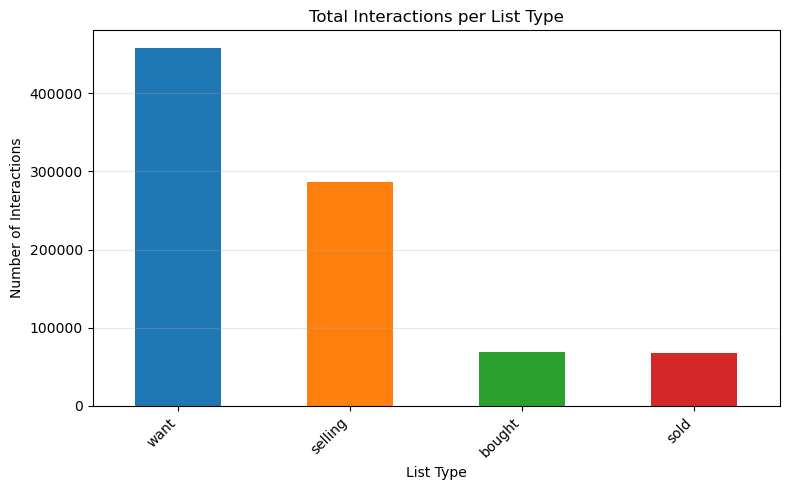

Interactions per list type:
list_type
want       457690
selling    286198
bought      68543
sold        67743
Name: count, dtype: int64


In [ ]:
# 1. Visualize interactions across list types (bar chart)
# Count interactions for each list type
list_type_counts = interactions_df["list_type"].value_counts()
plt.figure(figsize=(8, 5))
# Create bar chart with distinct colors for each list type
list_type_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.xlabel("List Type")
plt.ylabel("Number of Interactions")
plt.title("Total Interactions per List Type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print the exact counts for reference
print("Interactions per list type:")
print(list_type_counts)


Item popularity in 'want' lists:
count    165215.000000
mean          2.770269
std           3.278630
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         116.000000
dtype: float64


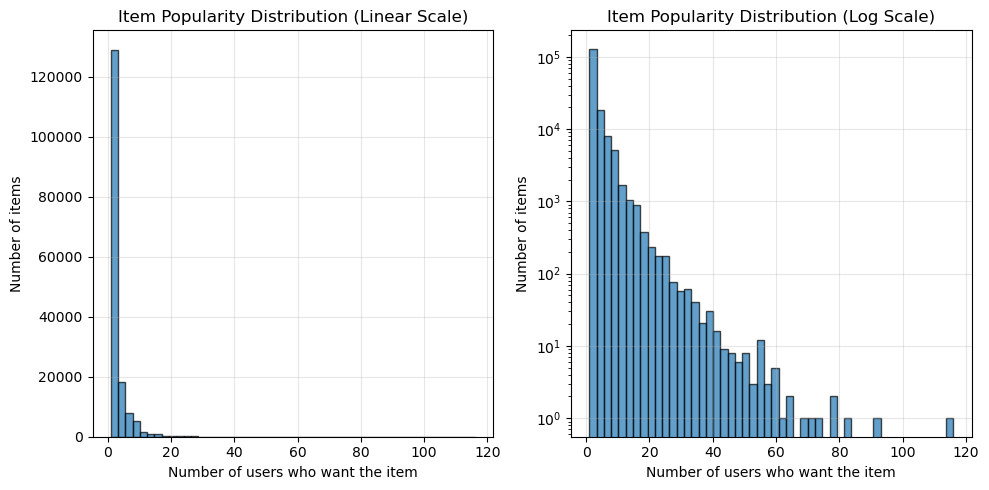


Top 20 most wanted items:
964662     116
1329704     91
686270      82
188497      77
1321591     77
903089      73
840047      71
133710      68
815163      64
1226731     64
1338267     62
1331515     60
1324709     60
376394      60
1334863     59
1078009     59
30858       58
833281      58
709179      58
747614      56
dtype: int64


In [ ]:
# 2. Item popularity distribution (how many users want each item)
# Compute item popularity: count how many users have each item in their want list
# This is a key feature for our prediction model
item_want_pop_viz = Counter(want_df["item_id"])
# Convert to pandas Series for easier analysis
item_pop_counts = pd.Series(list(item_want_pop_viz.values()))
print("Item popularity in 'want' lists:")
print(item_pop_counts.describe())

# Plot distribution with both linear and log scales
# Log scale helps visualize the long tail of item popularity
plt.figure(figsize=(10, 5))

# Left subplot: linear scale (shows full distribution)
plt.subplot(1, 2, 1)
plt.hist(item_pop_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of users who want the item")
plt.ylabel("Number of items")
plt.title("Item Popularity Distribution (Linear Scale)")
plt.grid(alpha=0.3)

# Right subplot: log scale (better for visualizing long tail)
plt.subplot(1, 2, 2)
plt.hist(item_pop_counts[item_pop_counts > 0], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of users who want the item")
plt.ylabel("Number of items")
plt.title("Item Popularity Distribution (Log Scale)")
plt.yscale("log")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identify top 20 most wanted items (most popular items)
top_items = pd.Series(item_want_pop_viz).nlargest(20)
print("\nTop 20 most wanted items:")
print(top_items)


User activity (total unique items per user):
count    128152.000000
mean          6.662346
std          26.761842
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2408.000000
Name: item_id, dtype: float64


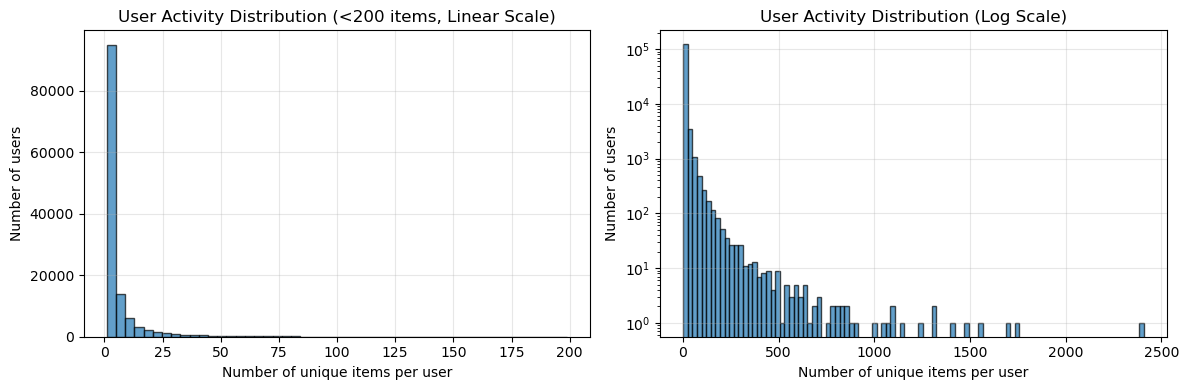

In [ ]:
# 3. User activity distribution (total interactions per user)
# Count unique items per user across all list types
# This measures overall user engagement with the platform
interactions_per_user = interactions_df.groupby("user_id")["item_id"].nunique()
print("User activity (total unique items per user):")
print(interactions_per_user.describe())

plt.figure(figsize=(12, 4))

# Left subplot: linear scale for users with <200 items (typical users)
plt.subplot(1, 2, 1)
subset_active = interactions_per_user[interactions_per_user < 200]
plt.hist(subset_active, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of unique items per user")
plt.ylabel("Number of users")
plt.title("User Activity Distribution (<200 items, Linear Scale)")
plt.grid(alpha=0.3)

# Right subplot: log scale to show full distribution including power users
plt.subplot(1, 2, 2)
plt.hist(interactions_per_user, bins=100, edgecolor="black", alpha=0.7)
plt.xlabel("Number of unique items per user")
plt.ylabel("Number of users")
plt.title("User Activity Distribution (Log Scale)")
plt.yscale("log")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


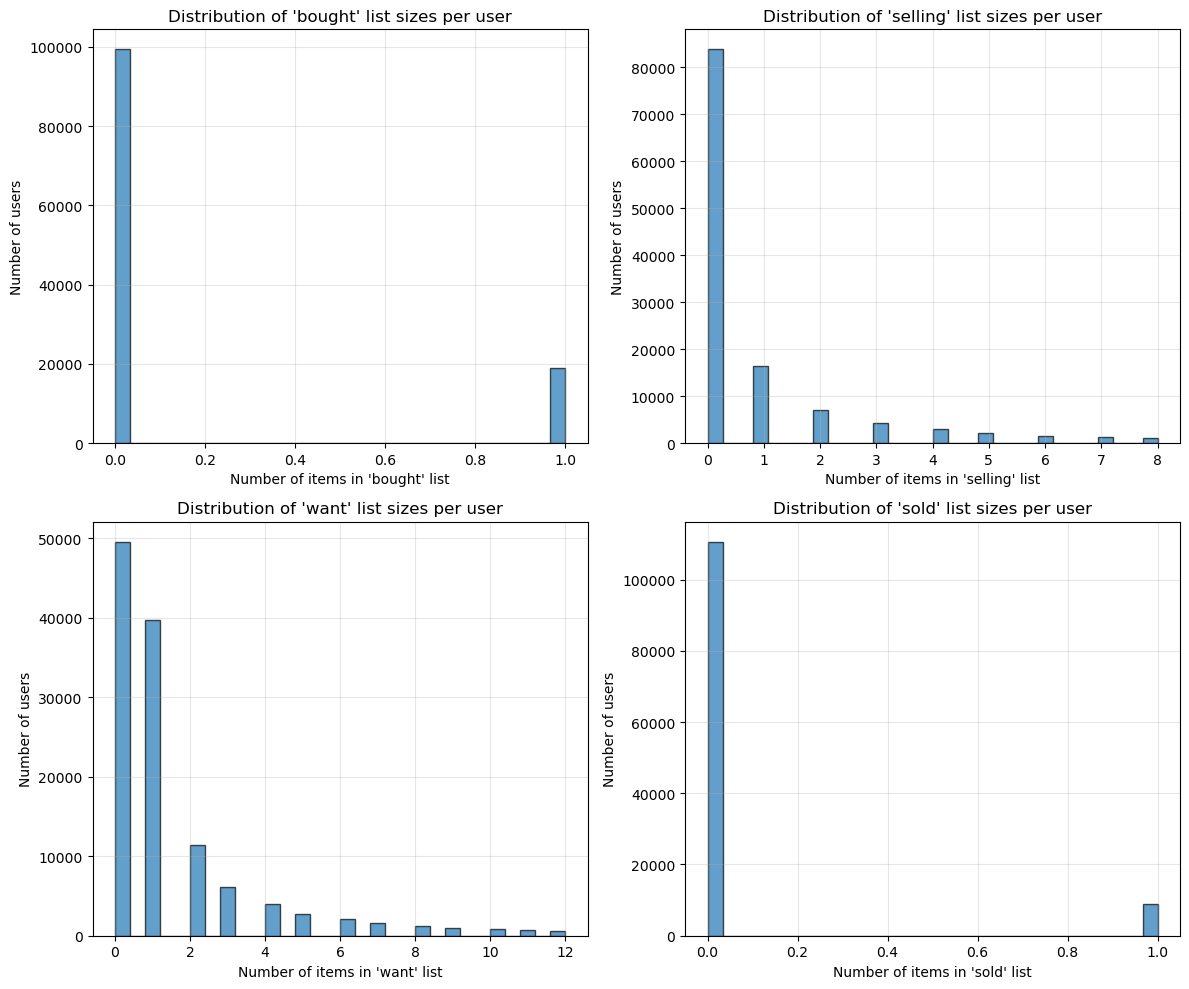

Summary of list sizes per user:
list_type         bought        selling           sold           want
count      128152.000000  128152.000000  128152.000000  128152.000000
mean            0.534857       2.233270       0.528614       3.571462
std             2.586872      13.435591       4.576944      20.204708
min             0.000000       0.000000       0.000000       0.000000
25%             0.000000       0.000000       0.000000       0.000000
50%             0.000000       0.000000       0.000000       1.000000
75%             0.000000       1.000000       0.000000       2.000000
max           223.000000    1144.000000     756.000000    2396.000000


In [ ]:
# 4. Distribution of items across different list types per user
# Create a pivot table: rows=users, columns=list_types, values=count of items
list_type_per_user = interactions_df.groupby(["user_id", "list_type"]).size().unstack(fill_value=0)

# Create 2x2 grid of subplots for each list type
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
list_types = ["bought", "selling", "want", "sold"]

# Plot histogram for each list type
for idx, lt in enumerate(list_types):
    ax = axes[idx // 2, idx % 2]
    data = list_type_per_user[lt]
    # Clip extreme values (top 5%) for better visualization
    # This removes outliers that would compress the histogram
    data_clipped = data[data < data.quantile(0.95)]
    ax.hist(data_clipped, bins=30, edgecolor="black", alpha=0.7)
    ax.set_xlabel(f"Number of items in '{lt}' list")
    ax.set_ylabel("Number of users")
    ax.set_title(f"Distribution of '{lt}' list sizes per user")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for each list type
print("Summary of list sizes per user:")
print(list_type_per_user.describe())


## 2.6 Data Filtering

We will restrict our predictive task to users who have at least one `want` item, so that we have clear positive examples.


## 2.7 Building User-Centric Lookup Structures

For efficient negative sampling and feature computation, we construct:

- `user_lists[user_id][list_type] = set(item_ids)` for each list type
- `global_items`: the set of all items seen in any list
- `item_want_popularity[item_id]`: how many users have this item in `want`


In [ ]:
# Build user_lists: user -> {list_type -> set(items)}
# This data structure allows fast lookup of which items are in each user's lists
# We use sets for O(1) membership testing
user_lists = defaultdict(lambda: {lt: set() for lt in LIST_TYPES})

# Populate the user_lists dictionary from the interactions DataFrame
for _, row in interactions_df.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    lt = row["list_type"]
    # Add item to the appropriate list for this user
    user_lists[u][lt].add(i)

# Global item sets: all items that appear in any list
# These are used for negative sampling (sampling items not in user's want list)
global_items_any = set(interactions_df["item_id"].unique())
global_items_want = set(want_df["item_id"].unique())

# Item popularity in 'want' lists: count how many users want each item
# This will be used as a feature in our model
item_want_popularity = Counter(want_df["item_id"])

# Print summary statistics
print(f"Users in user_lists: {len(user_lists):,}")
print(f"Items in any list: {len(global_items_any):,}")
print(f"Items in want lists: {len(global_items_want):,}")

Users in user_lists: 128,152
Items in any list: 352,865
Items in want lists: 165,215


In [ ]:
# Import tqdm for progress bars during long operations
from tqdm import tqdm
import numpy as np
import pandas as pd

# Number of negative samples to generate per positive sample
# This creates a balanced dataset (20% positive, 80% negative)
NEG_PER_POS = 4

# Precompute global items list as a NumPy array for fast sampling
# NumPy random.choice is faster than Python random.choice for large arrays
global_items_list = np.array(list(global_items_any))


def sample_training_pairs(user_lists, global_items_list, neg_per_pos=4):
    """
    Generate positive and negative training pairs for the want prediction task.
    
    For each user, creates:
    - Positive pairs: (user, item) where item is in user's want list
    - Negative pairs: (user, item) where item is NOT in user's want list
                      (sampled uniformly from all items)
    
    Args:
        user_lists (dict): Dictionary mapping user_id to dict of list_type -> set(items)
        global_items_list (np.array): Array of all item IDs for negative sampling
        neg_per_pos (int): Number of negative samples per positive sample. Defaults to 4.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['user_id', 'item_id', 'label']
                      where label=1 for positive pairs, label=0 for negative pairs
    """
    pos_rows = []  # Store positive examples
    neg_rows = []  # Store negative examples

    # Iterate through all users with progress bar
    for u, lists in tqdm(user_lists.items(), desc="Sampling user-item pairs", unit="user"):
        want_items = lists["want"]
        # Skip users with no want items (no positive examples)
        if not want_items:
            continue

        # Convert to list for iteration and set for fast membership testing
        want_items_list = list(want_items)
        want_set = set(want_items)  # O(1) membership testing

        # For each item in user's want list, create a positive example
        for i in want_items_list:
            # Positive sample: user wants this item
            pos_rows.append((u, i, 1))

            # Draw negative samples: items NOT in user's want list
            neg_samples = []
            while len(neg_samples) < neg_per_pos:
                # Sample uniformly from all items
                cand = np.random.choice(global_items_list)
                # Only add if item is not in user's want list
                if cand not in want_set:
                    neg_samples.append(cand)

            # Create negative examples for each sampled negative item
            for j in neg_samples:
                neg_rows.append((u, j, 0))

    # Combine positive and negative examples into single DataFrame
    df = pd.DataFrame(
        pos_rows + neg_rows,
        columns=["user_id", "item_id", "label"]
    )
    return df


# Generate training pairs with 4 negatives per positive
pairs_df = sample_training_pairs(user_lists, global_items_list, NEG_PER_POS)
print(f"Constructed {len(pairs_df):,} user–item training pairs.")
pairs_df.head()

Sampling user-item pairs: 100%|██████████| 128152/128152 [00:07<00:00, 17444.45user/s]


Constructed 2,288,450 user–item training pairs.


,user_id,item_id,label
0,8,7596,1
1,9,1451680,1
2,9,405246,1
3,9,30858,1
4,9,405269,1


In [ ]:
print("Label distribution (1=want, 0=not want):")
display(pairs_df["label"].value_counts(normalize=True).rename("proportion"))

Label distribution (1=want, 0=not want):


label
0    0.8
1    0.2
Name: proportion, dtype: float64

# Section 3: Modeling

## 3.1 Task Formulation as an ML Problem

**Inputs**: Feature vectors for each (user, item) pair, including:
- User-side features: total items, want count
- Item-side features: popularity in want lists
- User-item interaction features: whether item appears in user's bought/selling/sold lists

**Outputs**: Binary prediction (1 = user wants item, 0 = user does not want item)

**Optimization**: We optimize for binary classification using logistic regression, which minimizes the cross-entropy loss between predicted probabilities and true labels.

**Models appropriate for this task**:
- **Logistic Regression**: Interpretable, efficient, good baseline for structured features
- **Matrix Factorization**: Could learn latent user/item factors (not implemented here, but discussed as extension)
- **Neural Collaborative Filtering**: Could capture non-linear interactions (not implemented here)

---

## 3.2 Feature Engineering

For each \((u, i)\) pair, we construct simple, interpretable features:

- **User-side features**
  - `user_total_items`: total #items across all lists (`bought` + `selling` + `want` + `sold`)
  - `user_want_count`: #want items for user
- **Item-side features**
  - `item_want_pop`: how many users have item in their `want` list
- **User–item interaction features**
  - `in_bought`: 1 if item is in user's `bought` list, else 0
  - `in_selling`: 1 if item is in user's `selling` list, else 0
  - `in_sold`: 1 if item is in user's `sold` list, else 0

### Feature Engineering Rationale

**User-side features**:
- **`user_total_items`**: Captures overall user activity level. Rationale: Active users (many interactions) may have different preferences or engagement patterns than inactive users.
- **`user_want_count`**: Directly measures how many items a user wants. Rationale: Users with large want lists may be more likely to add new items (high intent), or may have broader preferences. This is a strong signal for the target variable.

**Item-side features**:
- **`item_want_pop`**: Measures item popularity in want lists. Rationale: Popular items are more likely to be wanted by new users (collaborative filtering signal). This captures the "wisdom of the crowd" effect.

**User–item interaction features**:
- **`in_bought`**: Whether the user has purchased this item. Rationale: Users may want items they've previously bought (repurchase intent) or may not want items they already own (saturation).
- **`in_selling`**: Whether the user is selling this item. Rationale: Users selling an item may not want it (they're getting rid of it), or may want similar items (style preference).
- **`in_sold`**: Whether the user has sold this item. Rationale: Similar to `in_selling`—past selling behavior may indicate preferences or dispreferences.

**Design choices**:
- **Binary interaction features**: We use binary indicators (0/1) rather than counts because:
  - Simplicity: Easy to interpret and compute
  - Sufficiency: The presence/absence of interaction is the key signal
  - Sparsity: Most user–item pairs have no interaction, so binary encoding is natural

- **No normalization initially**: We keep raw counts for user/item features because:
  - Logistic regression with standardization can handle different scales
  - Raw values are interpretable
  - We apply `StandardScaler` during model training to normalize features

- **Feature selection rationale**: 
We chose these features because they:
  - Are directly available from the dataset (no external data needed)
  - Capture key signals: user behavior, item popularity, historical interactions
  - Are interpretable and align with domain knowledge about e-commerce behavior
  - Provide a good baseline that can be extended with more sophisticated features


In [ ]:
# Precompute user-level features for efficiency
# These features are computed once and reused for all pairs involving each user
user_total_items = {}  # Total unique items across all lists per user
user_want_count = {}   # Number of items in user's want list

for u, lists in user_lists.items():
    # Union all items across all list types to get total unique items
    all_items_u = set().union(*lists.values())
    user_total_items[u] = len(all_items_u)
    user_want_count[u] = len(lists["want"])

# Convert item_want_popularity counter to a dict with default 0
# This allows fast lookup with default value for items not in any want list
item_want_pop_dict = defaultdict(int, item_want_popularity)


def build_feature_columns(pairs_df, user_lists, user_total_items, user_want_count, item_want_pop_dict):
    """
    Build feature matrix for user-item pairs.
    
    Creates the following features for each (user, item) pair:
    - User-side features: total items, want count
    - Item-side features: item popularity in want lists
    - User-item interaction features: binary indicators for bought/selling/sold
    
    Args:
        pairs_df (pd.DataFrame): DataFrame with columns ['user_id', 'item_id', 'label']
        user_lists (dict): Dictionary mapping user_id to dict of list_type -> set(items)
        user_total_items (dict): Dictionary mapping user_id to total unique items count
        user_want_count (dict): Dictionary mapping user_id to want list size
        item_want_pop_dict (dict): Dictionary mapping item_id to popularity count
    
    Returns:
        pd.DataFrame: Feature matrix with one row per (user, item) pair
    """
    feats = {}
    
    # User-side features: map user_id to precomputed values
    feats["user_total_items"] = pairs_df["user_id"].map(lambda u: user_total_items.get(u, 0))
    feats["user_want_count"] = pairs_df["user_id"].map(lambda u: user_want_count.get(u, 0))
    
    # Item-side features: map item_id to popularity (default 0 if not found)
    feats["item_want_pop"] = pairs_df["item_id"].map(lambda i: item_want_pop_dict[i])
    
    # User-item interaction features: binary indicators
    # Helper function to check if item is in user's specific list
    def in_list(u, i, list_name):
        """Check if item i is in user u's list of type list_name."""
        return int(i in user_lists[u][list_name]) if u in user_lists else 0
    
    # Create binary features for each interaction type
    feats["in_bought"] = [
        in_list(u, i, "bought") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]
    feats["in_selling"] = [
        in_list(u, i, "selling") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]
    feats["in_sold"] = [
        in_list(u, i, "sold") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]
    
    # Convert dictionary of features to DataFrame
    feat_df = pd.DataFrame(feats)
    return feat_df


# Build feature matrix for all user-item pairs
feature_df = build_feature_columns(pairs_df, user_lists, user_total_items, user_want_count, item_want_pop_dict)
print("Feature matrix shape:", feature_df.shape)
feature_df.head()

Feature matrix shape: (2288450, 6)


,user_total_items,user_want_count,item_want_pop,in_bought,in_selling,in_sold
0,2,1,2,0,0,0
1,31,30,6,0,0,0
2,31,30,1,0,0,0
3,31,30,58,0,0,0
4,31,30,1,0,0,0


## 3.3 Train/Validation Split

We now split the \((u, i)\) pairs into:

- **Train set:** 80%
- **Validation set:** 20%

We stratify by the label to preserve the positive/negative ratio.


In [ ]:
# Prepare features and labels for train/validation split
X = feature_df  # Feature matrix
y = pairs_df["label"].astype(int)  # Binary labels (1=want, 0=not want)

# Split into train (80%) and validation (20%) sets
# Stratification ensures same positive/negative ratio in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,  # For reproducibility
    stratify=y  # Preserve class distribution
)

# Verify split sizes and class balance
print("Train size:", X_train.shape, "Val size:", X_val.shape)
print("Train positive rate:", y_train.mean(), "Val positive rate:", y_val.mean())

Train size: (1830760, 6) Val size: (457690, 6)
Train positive rate: 0.2 Val positive rate: 0.2


## 3.4 Modeling Approaches: Advantages and Disadvantages

### Models Implemented

We will compare:

1. **Random baseline** – random scores for each pair  
2. **Popularity baseline** – uses only `item_want_pop`  
3. **Logistic regression** – uses all engineered features

### Discussion of Modeling Approaches

**Random Baseline**:
- **Advantages**: Trivial to implement, serves as lower bound
- **Disadvantages**: No learning, no signal
- **Complexity**: O(1) per prediction
- **Efficiency**: Extremely fast

**Item Popularity Baseline**:
- **Advantages**: Simple, interpretable, captures collaborative filtering signal, very fast
- **Disadvantages**: Ignores user-specific preferences, cannot personalize
- **Complexity**: O(1) per prediction (pre-computed lookup)
- **Efficiency**: Extremely fast, minimal memory

**Logistic Regression**:
- **Advantages**: 
  - Interpretable feature weights
  - Efficient training and prediction
  - Handles multiple feature types
  - Probabilistic outputs
  - Less prone to overfitting than complex models
- **Disadvantages**: 
  - Assumes linear feature interactions
  - Cannot capture complex non-linear patterns
  - Requires feature engineering
- **Complexity**: O(n_features × n_samples) for training, O(n_features) per prediction
- **Efficiency**: Very fast, scales well to large datasets
- **Implementation challenges**: 
  - Feature scaling needed for convergence
  - Class imbalance may require class weights
  - Threshold tuning for optimal precision/recall trade-off

**Alternative approaches not implemented** (discussed in extensions):
- **Matrix Factorization**: Could learn latent factors but requires more complex optimization
- **Neural Networks**: Could capture non-linearities but requires more data and computation


In [ ]:
def evaluate_predictions(y_true, y_pred, y_proba=None, label="model"):
    """
    Evaluate binary classification predictions using multiple metrics.
    
    Computes accuracy, precision, recall, F1-score, and optionally ROC-AUC.
    Also displays a confusion matrix for detailed performance analysis.
    
    Args:
        y_true (array-like): True binary labels (0 or 1)
        y_pred (array-like): Predicted binary labels (0 or 1)
        y_proba (array-like, optional): Predicted probabilities for positive class.
                                       Required for ROC-AUC calculation. Defaults to None.
        label (str): Name of the model for display purposes. Defaults to "model".
    
    Returns:
        dict: Dictionary containing all computed metrics
    """
    # Compute standard classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    
    # Compute ROC-AUC if probability scores are provided
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            # Handle edge case where all labels are same class
            auc = float("nan")
        metrics["roc_auc"] = auc

    # Display results in formatted output
    print(f"=== Evaluation: {label} ===")
    for k, v in metrics.items():
        print(f"{k:10s}: {v:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print()
    return metrics

In [ ]:
## Implementation: Random Baseline

# Random baseline: generate random scores and predictions
# This serves as a trivial lower bound to demonstrate that our models learn signal
rand_scores = np.random.rand(len(y_val))  # Random scores in [0, 1]
rand_preds = (rand_scores >= 0.5).astype(int)  # Threshold at 0.5 for binary predictions
rand_metrics = evaluate_predictions(y_val, rand_preds, rand_scores, label="Random baseline")

=== Evaluation: Random baseline ===
accuracy  : 0.4998
precision : 0.1993
recall    : 0.4974
f1        : 0.2846
roc_auc   : 0.4997
Confusion matrix:
 [[183232 182920]
 [ 46003  45535]]



In [ ]:
## Implementation: Popularity Baseline

# **Architectural choices**: 
# - Uses pre-computed `item_want_pop` feature (how many users want each item)
# - Normalizes scores to [0,1] range for ROC-AUC computation
# - Simple threshold at 0.5 for binary predictions

# Extract item popularity values from validation set
item_pop_val = X_val["item_want_pop"].values.astype(float)

# Normalize scores to [0, 1] range for ROC-AUC stability
# This ensures scores are on the same scale regardless of absolute popularity values
if item_pop_val.max() > 0:
    pop_scores = item_pop_val / item_pop_val.max()
else:
    # Edge case: all items have popularity 0
    pop_scores = item_pop_val

# Convert scores to binary predictions using 0.5 threshold
# Items with popularity above median are predicted as "want"
pop_preds = (pop_scores >= 0.5).astype(int)  # simple threshold; can be tuned
pop_metrics = evaluate_predictions(y_val, pop_preds, pop_scores, label="Item popularity baseline")

=== Evaluation: Item popularity baseline ===
accuracy  : 0.8006
precision : 0.9347
recall    : 0.0030
f1        : 0.0059
roc_auc   : 0.8735
Confusion matrix:
 [[366133     19]
 [ 91266    272]]



In [ ]:
## Implementation: Logistic Regression Model

# **Architectural choices and implementation details**:
# - **Feature scaling**: We use `StandardScaler` to normalize features (mean=0, std=1) 
#   because logistic regression is sensitive to feature scales
# - **Optimization**: Uses LBFGS solver (default) with max_iter=10,000 to ensure convergence
# - **Regularization**: Default L2 regularization (C=1.0) to prevent overfitting
# - **Class handling**: Uses default class weights (assumes balanced classes)
# - **Output**: Produces probability scores via `predict_proba()`, allowing threshold tuning

# Scale features: fit scaler on training data, then transform both train and validation
# This prevents data leakage (validation statistics don't influence training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_val_scaled = scaler.transform(X_val)  # Transform validation using training statistics

# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=10_000, random_state=RANDOM_SEED)
log_reg.fit(X_train_scaled, y_train)

# Generate predictions: probabilities and binary predictions
val_proba_lr = log_reg.predict_proba(X_val_scaled)[:, 1]  # Probability of positive class
val_pred_lr = (val_proba_lr >= 0.5).astype(int)  # Binary predictions at 0.5 threshold

# Evaluate model performance
lr_metrics = evaluate_predictions(y_val, val_pred_lr, val_proba_lr, label="Logistic Regression")

=== Evaluation: Logistic Regression ===
accuracy  : 0.8419
precision : 0.7381
recall    : 0.3244
f1        : 0.4507
roc_auc   : 0.8864
Confusion matrix:
 [[355613  10539]
 [ 61840  29698]]



# Section 4: Evaluation

## 4.1 Evaluation Metrics and Justification

### How Should This Task Be Evaluated?

We evaluate using multiple metrics because each captures different aspects of performance:

- **Accuracy**: Overall correctness, but can be misleading with class imbalance
- **Precision**: Important for avoiding false positives (recommending unwanted items)
- **Recall**: Important for capturing all items users want
- **F1-score**: Balances precision and recall
- **ROC-AUC**: Threshold-independent measure of discrimination ability, robust to class imbalance
- **Precision@k**: Ranking metric that reflects real-world recommender system usage

**Why these metrics are appropriate**:
- **ROC-AUC** is standard for binary classification and handles class imbalance well
- **Precision/Recall** are interpretable for business stakeholders
- **Precision@k** aligns with how recommendations are actually used (showing top-k items)

### Baselines for Comparison

1. **Random baseline**: Trivial lower bound (no learning)
2. **Item popularity baseline**: Non-trivial baseline using only item popularity
3. **Logistic regression**: Our main model using all features

We demonstrate improvement by showing that logistic regression outperforms both baselines across multiple metrics.

## 4.2 Evaluation Results: Model Comparison


In [ ]:
# Create comparison table of all model results
comparison_rows = []

def add_row(name, metrics_dict):
    """
    Helper function to add a model's metrics to the comparison table.
    
    Args:
        name (str): Name of the model
        metrics_dict (dict): Dictionary of metric names to values
    """
    row = {"model": name}
    row.update(metrics_dict)
    comparison_rows.append(row)

# Add results from all three models
add_row("Random baseline", rand_metrics)
add_row("Item popularity", pop_metrics)
add_row("Logistic Regression", lr_metrics)

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(comparison_rows)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,Random baseline,0.499830,0.199317,0.497444,0.284600,0.499667
1,Item popularity,0.800553,0.934708,0.002971,0.005924,0.873456
2,Logistic Regression,0.841860,0.738077,0.324434,0.450738,0.886395


## 4.2.1 Understanding Confusion Matrices

The confusion matrices displayed in the evaluation results show the breakdown of predictions for each model. A confusion matrix is a 2×2 table that summarizes the performance of a binary classifier:

```
                Predicted: 0    Predicted: 1
Actual: 0      True Negatives   False Positives
Actual: 1      False Negatives  True Positives
```

**Interpreting the confusion matrix values:**

- **True Negatives (TN)**: Items correctly predicted as "not want" (top-left)
- **False Positives (FP)**: Items incorrectly predicted as "want" (top-right)
- **False Negatives (FN)**: Items incorrectly predicted as "not want" (bottom-left)
- **True Positives (TP)**: Items correctly predicted as "want" (bottom-right)

**Specific interpretations for our models:**

1. **Random baseline** `[[183232, 182920], [46003, 45535]]`:
   - Shows approximately equal numbers in all four cells (~183K TN, ~183K FP, ~46K FN, ~46K TP)
   - This indicates random performance with no learning signal—the model is essentially guessing
   - The roughly 50/50 split reflects the random threshold at 0.5

2. **Item popularity baseline** `[[366133, 19], [91266, 272]]`:
   - Very high true negatives (366,133) and very low true positives (272)
   - Only 19 false positives, but 91,266 false negatives
   - This shows the model rarely predicts "want" (only 291 total positive predictions out of 457,690)
   - High precision (0.9347) because when it does predict "want", it's usually correct, but very low recall (0.0030) because it misses almost all actual "want" items

3. **Logistic Regression** `[[355613, 10539], [61840, 29698]]`:
   - Better balance: 355,613 true negatives, 29,698 true positives
   - 10,539 false positives and 61,840 false negatives
   - Shows improved recall (0.3244) compared to popularity baseline—captures ~32% of actual "want" items
   - Maintains good precision (0.7381)—when predicting "want", ~74% are correct
   - The model makes more positive predictions (40,237) than the popularity baseline, leading to better overall performance

The confusion matrix helps us understand the trade-offs between precision and recall that are summarized in the other metrics.


## 4.3 Ranking Metrics Implementation (Precision@k)

For recommender systems, it's often more appropriate to evaluate rankings rather than just binary classification.

**Evaluation protocol**:

1. For each user in the validation set, collect all \((u, i)\) pairs in the validation split.
2. Rank them by the model's score \(\hat{p}(y=1 \mid u, i)\).
3. Compute Precision@k for each user and average.

**Implementation details**: We group validation pairs by user, sort by predicted score, and compute the fraction of positive items in the top-k recommendations.


In [ ]:
def precision_at_k_per_user(pairs_df, scores, k=10):
    """
    Compute Precision@k metric for ranking evaluation.
    
    For each user, ranks their items by predicted score, then computes the fraction
    of positive items in the top-k recommendations. Returns the average across all users.
    
    This metric is appropriate for recommender systems where we care about the quality
    of top recommendations rather than binary classification accuracy.
    
    Args:
        pairs_df (pd.DataFrame): DataFrame with columns ['user_id', 'item_id', 'label']
        scores (array-like): Predicted scores for each pair (higher = more likely to be positive)
        k (int): Number of top items to consider. Defaults to 10.
    
    Returns:
        tuple: (mean_precision_at_k, number_of_users_evaluated)
    """
    df = pairs_df.copy()
    df["score"] = scores
    
    # Group by user and compute precision@k for each user
    precisions = []
    for u, group in df.groupby("user_id"):
        # Sort items by score (descending) to get top recommendations
        group = group.sort_values("score", ascending=False)
        top_k = group.head(k)
        
        # Skip users with no items in top-k
        if len(top_k) == 0:
            continue
        
        # Precision@k = fraction of positive items in top-k
        prec_k = top_k["label"].mean()
        precisions.append(prec_k)
    
    # Return mean precision and number of users evaluated
    if not precisions:
        return float("nan"), 0
    return float(np.mean(precisions)), len(precisions)


# Build a validation pairs DataFrame aligned with scores
# Use same indexing as validation set to ensure alignment
val_pairs = pairs_df.iloc[y_val.index]  # same indexing as X_val/y_val

# Compute Precision@5 and Precision@10 for logistic regression model
p_at_5, n_users_eval = precision_at_k_per_user(val_pairs, val_proba_lr, k=5)
p_at_10, _ = precision_at_k_per_user(val_pairs, val_proba_lr, k=10)

print(f"Precision@5 (logistic regression): {p_at_5:.4f} over {n_users_eval} users")
print(f"Precision@10 (logistic regression): {p_at_10:.4f}")

Precision@5 (logistic regression): 0.2555 over 63996 users
Precision@10 (logistic regression): 0.2264


### 4.3.1 Interpretation of Precision@k Results

The Precision@k results for logistic regression show:

- **Precision@5 = 0.2555**: On average, when we recommend the top 5 items to each user, approximately **25.5%** of those recommendations are items the user actually wants. This means that out of 5 recommendations, roughly 1-2 items are relevant.

- **Precision@10 = 0.2264**: When we expand to the top 10 recommendations, the precision slightly decreases to **22.6%**, meaning approximately 2-3 out of 10 recommendations are relevant.

**Key observations:**

1. **Precision@5 > Precision@10**: This is expected behavior as we increase k we include items with lower predicted scores which are less likely to be relevant. The model's best predictions are concentrated in the top few recommendations.

2. **Performance context**: A Precision@5 of 25.5% means the model successfully identifies relevant items in the top recommendations, which is valuable for a recommender system where users typically only see the top few suggestions.

3. **Evaluation coverage**: Results are computed over 63,996 users in the validation set, providing a robust estimate of ranking performance across the user base.

This was also explained in our presentation.


# Section 5: Discussion of Related Work

## 5.1 How Has This Dataset (or Similar Datasets) Been Used Before?

The Tradesy lists dataset is part of a family of implicit feedback recommendation datasets commonly used in recommender systems research:

- **Similar datasets**: Amazon product datasets, MovieLens (implicit feedback variant), Pinterest datasets
- **Common use cases**: 
  - Studying implicit feedback patterns (purchases, clicks, wishlists)
  - Evaluating collaborative filtering methods
  - Fashion and e-commerce recommendation research
  - Understanding user behavior in marketplaces

This dataset specifically captures multi-type interactions (bought, selling, want, sold) which is richer than simple purchase datasets and allows studying relationships between different interaction types.

---
## 5.2 How Has Prior Work Approached the Same (or Similar) Tasks?

**Implicit Feedback Recommendation** has been extensively studied:

1. **Matrix Factorization for Implicit Feedback** (Hu, Koren, Volinsky, 2008):
   - Uses weighted matrix factorization to handle implicit feedback
   - Treats all interactions as positive, uses confidence weights
   - Our approach differs by using explicit negative sampling and feature engineering

2. **Bayesian Personalized Ranking (BPR)** (Rendle et al., 2009):
   - Learns pairwise preferences from implicit feedback
   - Optimizes for ranking quality rather than classification
   - Our logistic regression approach is simpler but less tailored to ranking

3. **Neural Collaborative Filtering** (He et al., 2017):
   - Uses neural networks to learn non-linear user-item interactions
   - Our linear model is more interpretable but less expressive

4. **Feature-based approaches** (similar to ours):
   - Many works combine collaborative filtering with content features
   - Our feature engineering (user activity, item popularity, interaction history) aligns with common practices
---
## 5.3 How Do Our Results Match or Differ from Related Work?

**Similarities with related work**:
- **Item popularity as strong signal**: Our popularity baseline performs well (ROC-AUC ~0.87), consistent with findings that popularity is a strong baseline in implicit feedback settings
- **Feature engineering effectiveness**: Our logistic regression improves over popularity alone, showing that user-specific and interaction features add value
- **Class imbalance challenges**: We observe precision-recall trade-offs typical of implicit feedback tasks

**Differences from related work**:
- **Simpler model**: We use logistic regression rather than matrix factorization or neural networks, prioritizing interpretability
- **Explicit negative sampling**: We sample negatives explicitly rather than using all non-interactions (common in MF approaches)
- **Feature-based rather than latent factors**: We use engineered features rather than learning latent representations

**Limitations compared to state-of-the-art**:
- **No latent factors**: Matrix factorization could capture user-item similarities we miss
- **Linear interactions only**: Cannot model complex non-linear patterns
- **No temporal modeling**: Cannot capture preference drift over time
- **Simple negative sampling**: Hard negative mining could improve learning
---
## 5.4 Summary

In this notebook we:

1. **Section 1**: Defined the predictive task, evaluation strategy, baselines, and validity assessment
2. **Section 2**: Conducted exploratory analysis, described data collection, and documented preprocessing steps
3. **Section 3**: Formulated the ML problem, engineered features, and implemented multiple models with architectural discussions
4. **Section 4**: Evaluated models using appropriate metrics, compared against baselines, and implemented ranking metrics
5. **Section 5**: Discussed related work and how our approach compares to prior methods
